#  <center>学习率的前世今生</center>

## 1. 引言  

最近在看Sutton的Reinforcement Learning: An Introduction，第二章对学习率的讲解非常清楚，因此整理笔记形成此文，希望对大家有所帮助。  
（注：本文不会全面介绍强化学习，而是强调了学习率的作用，默认读者对强化学习的常见问题如多臂老虎机和基本更新过程有所了解）

## 2. 多臂老虎机问题

在多臂老虎机问题中，一个比较朴素的方法是用样本均值（sample average）的方法，估计每个选项的价值，来决定下一次选择。举例来说，医生给病人开药，有ABCD四种药物可选，医生根据病人服药的的反馈决定下一次开什么药，也就是对某种药物的历史效果（可以用病人的病情或者病人对药物的评分来衡量）求和，除以该药被服用的次数，得到均值，作为对此药物的效果的估计，最后选择估值最大的药物。  
其中，选项a在t+1时刻的价值Q的数学定义如下：
\begin{equation}
Q_{t+1}(a)=\frac{\sum_{i=1}^{t}R_i }{t} \tag{1}
\end{equation}

但这个方法有个问题是，需要记录所有历史选项和奖赏，随着选择次数增加，需要维护的历史记录也在增加，那么有没有更好的方法可以避免这个问题呢？通过推导公式发现，其实可以只保留上一次的历史记录，同样能够完成价值的更新：
\begin{equation}
Q_{t+1}=\frac{\sum_{i=1}^{t}R_i }{t} \\
= \frac{R_t+\sum_{i=1}^{t-1}R_i}{t}\\
= \frac{R_t+(t-1)\frac{\sum_{i=1}^{t-1}R_i}{t-1}}{t} \\
= \frac{R_t+(t-1)Q_t}{t} \\
= Q_t+\frac{1}{t}(R_t-Q_t)
\tag{2}
\end{equation}

从公式(1)和公式(2)可以看出，整个过程只需要记录上一时刻的奖赏，上一时刻的价值估计和选择的次数，就可以估计当前时刻的价值，两种方法是等价的，并且两者对历史所有的奖赏都没有区别对待，也就是说，所有奖赏的权重都是一样的，但这样的更新方式有个问题，就是不能很好地捕捉环境的变化。  
（注：$R_t$的权重是从公式(1)得到的，也就是1，而不是公式(2)中的更新系数1/t）  
举个例子来说，还是医生给病人开药，但ABCD这四种药物分别在春夏秋冬四个季节效果最好，也就是说，从上帝视角看，最好的治疗方法就是每个季节开对应效果最好的那种药，但医生没有上帝视角，他只能从病人的反馈中估计药物的治疗效果，如果对过去所有的奖赏赋予同样的权重，就无法在换季后尽快换药。   
（注：从随机过程的角度，这其实就是一个非平稳过程）  
应对这个问题的一个方法就是对最近的奖赏赋予更高的权重，对过去的奖赏赋予更低的权重，从公式(2)中可以看出，t时刻的奖赏的更新系数是1/t，是随时间递减的，现在我们把它看作一个一般性的参数$\alpha_t (\alpha_t\in [0,1])$，那么如何设置$\alpha_t$，就可以让过去的奖赏的权重衰减呢？    
（注：熟悉Rescorla Wagner模型的同学可能会发现，这里的更新系数其实就是RW模型中的学习率$\alpha$，此后称学习率）


我们先来把$\alpha_t$设置成常数$\alpha$，看看会发生什么？
\begin{equation}
Q_{t+1}=Q_t+\alpha(R_t-Q_t)\\
= \alpha R_t+(1-\alpha)Q_t \\
= \underline{\alpha R_t + (1-\alpha)\alpha R_{t-1}+(1-\alpha)^{2}\alpha R_{t-2}+...+(1-\alpha)^{t-1}\alpha R_1}+(1-\alpha)^tQ_1\\
= \underline{\sum_{i=1}^t \alpha(1-\alpha)^{t-i}R_i}+(1-\alpha)^tQ_1
\tag{3}
\end{equation}

从公式(3)可以看出，固定$\alpha$之后，奖赏的权重开始随着时间指数衰减，其中$i$时刻的奖赏的权重变成了$\alpha(1-\alpha)^{t-i}$，时间上从当前时刻往前倒推，t时刻的奖赏的权重是$\alpha$，t-1时刻的奖赏的权重是$\alpha(1-\alpha)$，t-2时刻的奖赏的权重是$\alpha(1-\alpha)^2$，时刻越久远，奖赏的权重越小，从下图中可以明显看出，在$\alpha$等于0.3时，时刻40之前的所有奖赏的权重都是小于0.05的，而在接近当前时刻t=50时，权重提高到了0.2左右：

Text(0, 0.5, 'reward weight')

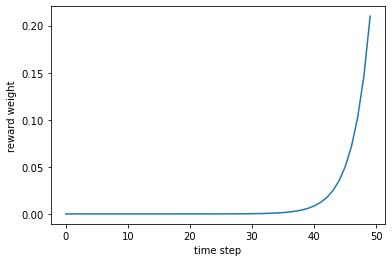

In [141]:
import numpy as np
import matplotlib.pyplot as plt
x=np.arange(0,50,1)
y=0.3*0.7**(len(x)-x)
plt.plot(x,y)
plt.xlabel("time step")
plt.ylabel("reward weight")

## 3. 模拟与比较

为了应对更一般的情况，也就是变化的环境，我们把$R_t$的学习率$\alpha_t$固定为常数，从而让奖赏的权重随时间衰减，但是这样的设置真的能让总的奖赏更大吗？我们来模拟一下在不变的环境和环境发生变化时，奖赏的权重固定（对应衰减的学习率$\alpha$）和奖赏的权重衰减（对应固定的学习率$\alpha$）对agent获得的奖赏的影响。

In [75]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i]>top_value:
            top_value=q_values[i]
    ties=[i for i, j in enumerate(q_values) if j == top_value]
    
    return np.random.choice(ties)

In [76]:
def epsilon_greedy_sample_average_agent(last_choice,last_reward,last_value,arm_counts,epsilon=0.1):
    q_values=last_value
    q_values[last_choice]=q_values[last_choice]+1/arm_counts[last_choice]*(last_reward-q_values[last_choice])
    if np.random.random() < epsilon:
        choice=np.random.randint(0,len(q_values))
    else:
        choice=argmax(q_values)
    return choice,q_values

In [77]:
def epsilon_greedy_constant_alpha_agent(last_choice,last_reward,last_value,alpha=0.1,epsilon=0.1):
    q_values=last_value
    q_values[last_choice]=q_values[last_choice]+alpha*(last_reward-q_values[last_choice])
    if np.random.random() < epsilon:
        choice=np.random.randint(0,len(q_values))
    else:
        choice=argmax(q_values)
    return choice,q_values

In [78]:
def feedback(choice,mu):
    # mu - machine setting: reward probability for each arm
    # machine_k give reward at the prob of mu[k-1]
    rand=np.random.uniform()
    reward = rand < mu[int(choice)]
    return reward

In [132]:
def simulate(agent,epsilon=0.05,alpha=0.1,T=100,k=4,mu=np.random.random(4)):
    arm_counts=np.zeros(k)
    choices=np.ones(T)
    arm_counts[1]=1
    rewards=np.zeros(T)
    q_values=np.zeros((T,k))
    for t in range(T-1):
        if agent==1:
            choices[t+1],q_values[t+1]=epsilon_greedy_sample_average_agent(int(choices[t]),rewards[t],q_values[t],arm_counts,epsilon)
        elif agent==2:
            choices[t+1],q_values[t+1]=epsilon_greedy_constant_alpha_agent(int(choices[t]),rewards[t],q_values[t],alpha,epsilon)
        arm_counts[int(choices[t+1])]+=1
        # non-stationary environment
        if t == T/2:
            mu = np.random.random(4)
        rewards[t+1]=feedback(choices[t+1],mu)
        
    return rewards

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 87.28it/s]


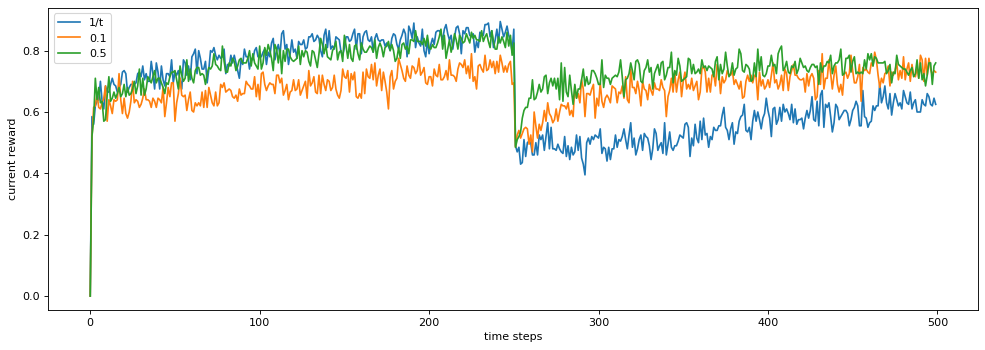

In [144]:
num_runs=200
num_steps=500
agent_info=[(1,0),(2,0.1),(2,0.5)]
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

for agent,lr in agent_info:
    rewards_allruns=np.zeros((num_runs,num_steps))
    for run in tqdm(range(num_runs)):
#         np.random.seed(run)
        rewards_allruns[run]=simulate(agent,alpha=lr,T=num_steps)
    plt.plot(np.mean(rewards_allruns, axis=0))
plt.legend([ "1/t","0.1","0.5"])
plt.xlabel("time steps")
plt.ylabel("current reward")
plt.show()

从上图可以看出，在环境不变时，也就是前250步，学习率为1/t远比0.1表现更好，略好于0.5，也就是获得的reward更多，当t=250时环境突然改变（也就是每个机器的奖赏概率/药物的效果发生了变化），此时固定的学习率0.1和0.5（也就是对过去的奖赏进行折扣）更快地捕捉了环境的变化，获得了更多的reward。而在通常情况下，agent所在的环境是动态变化的，因此将学习率设置为常数，能够更好地应对一般的环境。

（注：本文代码可以从[github](https://github.com/lynn0503/RL_Coursera.git)下载）